# Phishing Classification with a custom Transformer Encoder Model (Part 1)
```
Guillermo Molins
```

We start by importing the dataset

In [2]:
# Import libraries
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, roc_curve, auc

pd.options.display.float_format = '{:20,.2f}'.format

# Import dataset
df = pd.read_csv('./Phishing_Email.csv')
df.head()

Unnamed: 0                                         Email Text  \
0           0  re : 6 . 1100 , disc : uniformitarianism , re ...   
1           1  the other side of * galicismos * * galicismo *...   
2           2  re : equistar deal tickets are you still avail...   
3           3  \nHello I am your hot lil horny toy.\n    I am...   
4           4  software at incredibly low prices ( 86 % lower...   

       Email Type  
0      Safe Email  
1      Safe Email  
2      Safe Email  
3  Phishing Email  
4  Phishing Email

In [3]:
df.drop(df.columns[0], axis=1, inplace=True)

## Exploratory Data Analysis & Preprocessing

In [4]:
df.shape

(18650, 2)

In [5]:
df.isnull().sum()

Email Text    16
Email Type     0
dtype: int64

In [6]:
df.dropna(inplace=True)

In [7]:
df.shape

(18634, 2)

In [8]:
df["Email Type"].value_counts()

Email Type
Safe Email        11322
Phishing Email     7312
Name: count, dtype: int64

<Axes: >

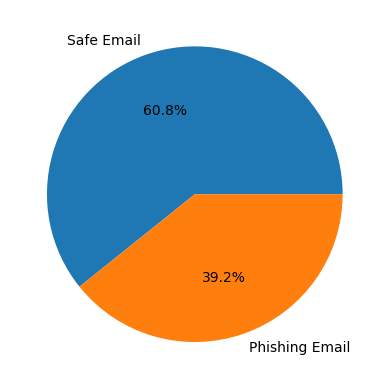

In [9]:
df["Email Type"].value_counts().plot(kind="pie", autopct='%1.1f%%', ylabel='')

The full sample consists of 18650 emails of which 7312 are categorized as phishing. We also have 16 null values which we can simply drop.

<Axes: >

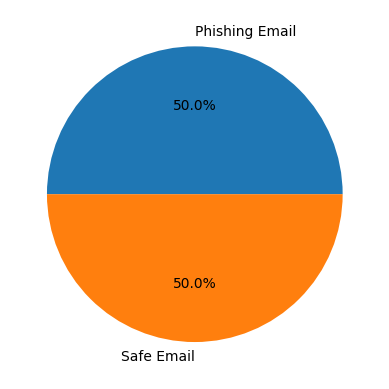

In [10]:
from imblearn.under_sampling import RandomUnderSampler

X = df.drop(columns=["Email Type"])
y = df["Email Type"]
texts_under, labels_under = RandomUnderSampler(random_state=100).fit_resample(X, y)
labels_under.value_counts().plot(kind="pie", autopct='%1.1f%%', ylabel='')

In [11]:
texts_under

Email Text
3      \nHello I am your hot lil horny toy.\n    I am...
4      software at incredibly low prices ( 86 % lower...
7      entourage , stockmogul newsletter ralph velez ...
8      we owe you lots of money dear applicant , afte...
10     make her beg you to give it to her everynight ...
...                                                  ...
13161  thanks thanks to all of the many people who se...
14405  At 12:32 PM 12/28/00 -0600, Adam Rifkin wrote:...
14027  benefits for terminated employees hi all , i j...
17259  re : question on office space in the new build...
14812  markedness - - bibliography dear list , a coup...

[14624 rows x 1 columns]

We opt by undersampling our data as 14624 samples should be enough for training

In [12]:
texts_under["Word Count"] = texts_under["Email Text"].apply(lambda texto: len(texto.split(" ")))
texts_under["Word Count"].describe()

count              14,624.00
mean                  341.53
std                   700.65
min                     1.00
25%                    72.00
50%                   158.00
75%                   355.00
max                18,971.00
Name: Word Count, dtype: float64

Emails have 341 words on average, we will consider this when defining the maximum token length of our model

Text(0, 0.5, 'Count')

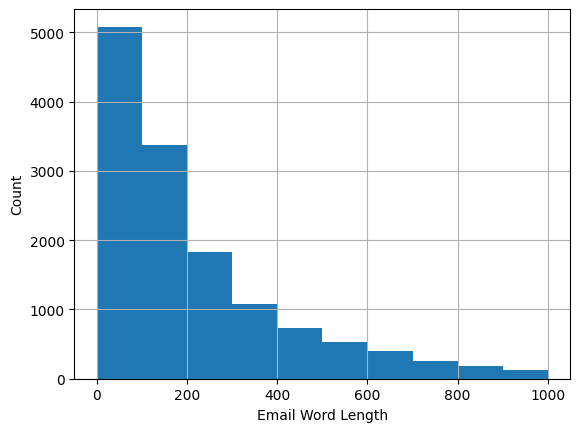

In [13]:
ax = texts_under["Word Count"].hist(range=[0, 1000])
ax.set_xlabel('Email Word Length')
ax.set_ylabel('Count')

In [14]:
from sklearn.preprocessing import LabelEncoder

encoded_labels = labels_under.apply(lambda x: 1 if x == "Phishing Email" else 0)

In [15]:
import re

def parse_sentence(text: str):
    text = text.lower()
    text = re.sub(r'["#%&\'()*@+\-;_,./:=<>[\]^`{|}~―]', ' ', text)
    text = re.sub(r'[^\x00-\x7F]', ' ', text)
    text = re.sub(r'!+', ' ! ', text)
    text = re.sub(r'\?+', ' ? ', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[\d-]', '', text)
    clean_text = ""
    for word in text.split(" "):
        if "http" in word or ".com" in word:
            word = "http"

        clean_text += word + " "
    clean_text = re.sub(r'\s+', ' ', clean_text).strip()
    return clean_text[:-1]

texts_clean = texts_under["Email Text"].apply(lambda texto: parse_sentence(texto))

We create a function to parse the text of our emails. We dispose off some information such as usernames and HTTP links. We also remove most type symbols and and trailing whitespaces.

In [16]:
import nltk
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

nltk.download('punkt')  # Download the tokenizer models if not already downloaded
tokenized_corpus = [word_tokenize(text.lower()) for text in texts_clean.values] # Lowercasing for consistency
skipgram_model = Word2Vec(sentences=tokenized_corpus,
                          vector_size=128,  # Dimensionality of the word vectors
                          window=5,         # Maximum distance between the current and predicted word within a sentence
                          sg=1,             # Skip-Gram model (1 for Skip-Gram, 0 for CBOW)
                          min_count=1,      # Ignores all words with a total frequency lower than this
                          workers=-1)        # Number of CPU cores to use for training the model
# Training
skipgram_model.train([tokenized_corpus], total_examples=1, epochs=10)
skipgram_model.save("Models/word2vec/skipgram_model.model")
loaded_model = Word2Vec.load("Models/word2vec/skipgram_model.model")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\guimo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


We create a skip-gram type embedding with vector size 128. This will serve as the base for our embedding matrix, which connects index ids with the embedding tensors

In [17]:
import numpy as np 
import torch

new_vocab_size = len(loaded_model.wv)
new_embedding_dim = loaded_model.vector_size

# Create an embedding matrix
embedding_matrix = np.zeros((new_vocab_size, new_embedding_dim))
word2index = {word: idx for idx, word in enumerate(loaded_model.wv.index_to_key)}

for word, idx in word2index.items():
    embedding_matrix[idx] = loaded_model.wv[word]

# Convert embedding matrix to a tensor
embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32, requires_grad=True)

In [18]:
embedding_matrix.shape

torch.Size([123768, 128])

## Model Definition

We define a model with an embedding layer, 2 layers of TransformerEncoders and a linear FC layer. The transformer encoder works with 4 attention heads and a 30% dropout rate.

In [19]:
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer

class TransformerModel(nn.Module):
    def __init__(self, embedding_matrix, num_encoder_layers=2, nhead=4, dropout=0.3):
        super(TransformerModel, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight = nn.Parameter(embedding_matrix)
        self.dropout = nn.Dropout(dropout)
        encoder_layer = TransformerEncoderLayer(d_model=embedding_dim, nhead=nhead, batch_first=True, dropout=dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.fc = nn.Linear(embedding_dim, 1)

    def forward(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)  # Global average pooling
        x = self.fc(x)
        return x.squeeze(1)
    
    def get_embedding(self, x):
        return self.embedding(x)
    
    def adv_forward(self, x):
        x = self.dropout(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)  # Global average pooling
        x = self.fc(x)
        return x.squeeze(1)

We define a Dataset class to preprocess and store our sample data in the form of embedding indices.

In [20]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import DataLoader, random_split

class TextDataset(Dataset):
    def __init__(self, texts, labels, word2index):
        self.texts = texts
        self.labels = labels
        self.word2index = word2index
        self.max_len = 1024

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx].split()
        label = self.labels[idx]
        indices = [self.word2index.get(word, 0) for word in text]  # Use 0 for unknown words
        # Pad or truncate the sequence to max_len
        padded_indices = indices
        if len(indices) < self.max_len:
            padded_indices = indices + [0] * (self.max_len - len(indices))
        padded_indices = padded_indices[:self.max_len]
        return torch.tensor(padded_indices, dtype=torch.long), torch.tensor(label, dtype=torch.float32)

# Split the dataset into training and validation sets
dataset = TextDataset(texts_clean.values, encoded_labels.values, word2index)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

torch.manual_seed(100)

We split our data into the following proportions:
* 70% Train
* 15% Validation
* 15% Test

## Model Training

We train the model for 5 iterations of randomized data. The maximum number of training epochs is set to 20. We establish an adaptive LR of 0,0001 with 4 epochs for patience and 8 epochs for early stopping. The model criterion is Binary Cross Entropy with logits loss.

In [153]:
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

for seed in range(5):
    model = TransformerModel(embedding_matrix)

    # Load model to device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    print(f'\nIteration: {seed}')
    # Define loss function and optimizer
    criterion = nn.BCEWithLogitsLoss()
    optimizer = Adam(model.parameters(), lr=2e-5)
    scheduler = ReduceLROnPlateau(optimizer, mode='min' , factor=0.1, patience=2)

    # Training loop
    num_epochs = 15

    # Define early stopping parameters
    early_stopping_patience = 3
    best_val_loss = float('inf')
    patience_counter = 0

    generator = torch.Generator().manual_seed(seed)
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for inputs, label in train_loader:
            inputs, label = inputs.to(device), label.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, label)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
        train_loss /= len(train_loader.dataset)

        # Validation loop
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for inputs, label in val_loader:
                inputs, label = inputs.to(device), label.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, label)
                val_loss += loss.item() * inputs.size(0)

        val_loss /= len(val_loader.dataset)
        scheduler.step(val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save the best model
            torch.save(model.state_dict(), f'Models/custom/best_custom_model_{seed}.pt')
        else:
            patience_counter += 1

        if patience_counter >= early_stopping_patience:
            print("Early stopping triggered")
            break


Iteration: 0
Epoch 1/15, Train Loss: 0.4926, Val Loss: 0.1566
Epoch 2/15, Train Loss: 0.1034, Val Loss: 0.0991
Epoch 3/15, Train Loss: 0.0609, Val Loss: 0.1041
Epoch 4/15, Train Loss: 0.0425, Val Loss: 0.1015
Epoch 5/15, Train Loss: 0.0319, Val Loss: 0.1009
Early stopping triggered

Iteration: 1
Epoch 1/15, Train Loss: 0.5149, Val Loss: 0.1384
Epoch 2/15, Train Loss: 0.0942, Val Loss: 0.1031
Epoch 3/15, Train Loss: 0.0565, Val Loss: 0.0893
Epoch 4/15, Train Loss: 0.0399, Val Loss: 0.1232
Epoch 5/15, Train Loss: 0.0321, Val Loss: 0.1102
Epoch 6/15, Train Loss: 0.0281, Val Loss: 0.1129
Early stopping triggered

Iteration: 2
Epoch 1/15, Train Loss: 0.4990, Val Loss: 0.1632
Epoch 2/15, Train Loss: 0.1050, Val Loss: 0.1179
Epoch 3/15, Train Loss: 0.0626, Val Loss: 0.1272
Epoch 4/15, Train Loss: 0.0421, Val Loss: 0.1058
Epoch 5/15, Train Loss: 0.0341, Val Loss: 0.1093
Epoch 6/15, Train Loss: 0.0304, Val Loss: 0.1157
Epoch 7/15, Train Loss: 0.0270, Val Loss: 0.1121
Early stopping triggered



## Performance Metrics

In [154]:
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

for seed in range(5):
    # Load the best model
    model.load_state_dict(torch.load(f'Models/custom/best_custom_model_{seed}.pt'))

    # Evaluation on test set
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

    # Print metrics
    print(f'\nIteration: {seed}')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')


Iteration: 0
Accuracy: 0.9736
Precision: 0.9672
Recall: 0.9824
F1 Score: 0.9747

Iteration: 1
Accuracy: 0.9804
Precision: 0.9732
Recall: 0.9895
F1 Score: 0.9813

Iteration: 2
Accuracy: 0.9841
Precision: 0.9767
Recall: 0.9930
F1 Score: 0.9848

Iteration: 3
Accuracy: 0.9841
Precision: 0.9759
Recall: 0.9939
F1 Score: 0.9848

Iteration: 4
Accuracy: 0.9708
Precision: 0.9662
Recall: 0.9781
F1 Score: 0.9721


In [155]:
print('Overall:')
print(f'Average Accuracy: {np.mean(accuracy_list)}')
print(f'Average Precision: {np.mean(precision_list)}')
print(f'Average Recall: {np.mean(recall_list)}')
print(f'Average F1: {np.mean(f1_list)}')

Overall:
Average Accuracy: 0.9785876993166287
Average Precision: 0.9718214694778672
Average Recall: 0.9873573309920983
Average F1: 0.9795268237388759


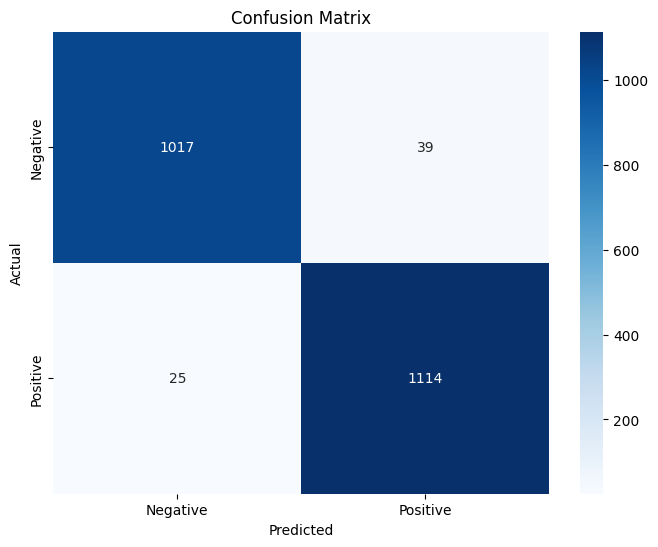

In [156]:
# Plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

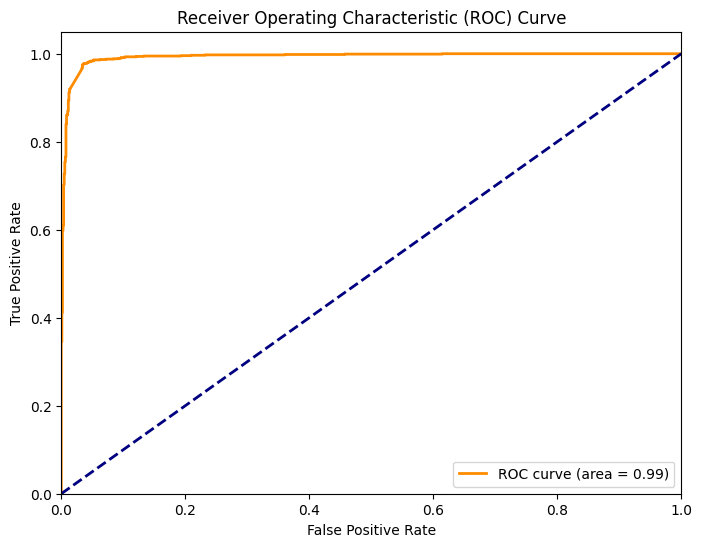

In [157]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [158]:
torch.cuda.empty_cache()

# Adversarial Sample Training

We define a function to generate adversarial samples based on the original ones

In [124]:
def fgsm_attack(inputs, epsilon, gradient):
    # Get the sign of the gradient
    sign_grad = gradient.sign()
    # Create the perturbed embedding
    perturbed_inputs = inputs + epsilon * sign_grad
    return perturbed_inputs

In [125]:
print(embedding_matrix.mean())
print(embedding_matrix.std())

tensor(7.1549e-07, grad_fn=<MeanBackward0>)
tensor(0.0045, grad_fn=<StdBackward0>)


We base the value of epsilon in the degree of variance for our embedding matrix. This way we ensure to not generate changes too big for the model to generalize

In [126]:
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

for seed in range(5):
    model = TransformerModel(embedding_matrix)

    # Load model to device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    print(f'\nIteration: {seed}')
    # Define loss function and optimizer
    criterion = nn.BCEWithLogitsLoss()
    optimizer = Adam(model.parameters(), lr=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='min' , factor=0.1, patience=2)

    # Training loop
    num_epochs = 15

    # Define early stopping parameters
    early_stopping_patience = 3
    best_val_loss = float('inf')
    patience_counter = 0

    generator = torch.Generator().manual_seed(seed)
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for inputs, label in train_loader:
            inputs, label = inputs.to(device), label.to(device)

            # Forward pass on clean examples
            optimizer.zero_grad()
            embeddings = model.get_embedding(inputs)
            outputs = model.adv_forward(embeddings)
            loss = criterion(outputs, label)
            embeddings.retain_grad()
            loss.backward(retain_graph=True)
            optimizer.step()

            # Generate adversarial examples
            perturbed_data = fgsm_attack(embeddings, epsilon=0.01, gradient=embeddings.grad.data)
            perturbed_data = perturbed_data.detach()
            
            # Forward pass on adversarial examples
            optimizer.zero_grad()
            adv_outputs = model.adv_forward(perturbed_data)
            adv_loss = criterion(adv_outputs, label)
            adv_loss.backward()
            optimizer.step()

            train_loss += ((loss.item() + adv_loss.item())/2) * inputs.size(0)
        train_loss /= len(train_loader.dataset)

        # Validation loop
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for inputs, label in val_loader:
                inputs, label = inputs.to(device), label.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, label)
                val_loss += loss.item() * inputs.size(0)

        val_loss /= len(val_loader.dataset)
        scheduler.step(val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save the best model
            torch.save(model.state_dict(), f'Models/custom/best_adv_custom_model_{seed}.pt')
        else:
            patience_counter += 1

        if patience_counter >= early_stopping_patience:
            print("Early stopping triggered")
            break


Iteration: 0
Epoch 1/15, Train Loss: 0.7158, Val Loss: 0.6934
Epoch 2/15, Train Loss: 0.6565, Val Loss: 0.1993
Epoch 3/15, Train Loss: 0.3498, Val Loss: 0.1145
Epoch 4/15, Train Loss: 0.1453, Val Loss: 0.1275
Epoch 5/15, Train Loss: 0.0921, Val Loss: 0.2596
Epoch 6/15, Train Loss: 0.0590, Val Loss: 0.1961
Early stopping triggered

Iteration: 1
Epoch 1/15, Train Loss: 0.7170, Val Loss: 0.7076
Epoch 2/15, Train Loss: 0.4232, Val Loss: 0.1478
Epoch 3/15, Train Loss: 0.0652, Val Loss: 0.1401
Epoch 4/15, Train Loss: 0.0658, Val Loss: 0.1289
Epoch 5/15, Train Loss: 0.0408, Val Loss: 0.1631
Epoch 6/15, Train Loss: 0.0264, Val Loss: 0.1836
Epoch 7/15, Train Loss: 0.0169, Val Loss: 0.2334
Early stopping triggered

Iteration: 2
Epoch 1/15, Train Loss: 0.7146, Val Loss: 0.6912
Epoch 2/15, Train Loss: 0.5544, Val Loss: 0.2403
Epoch 3/15, Train Loss: 0.3171, Val Loss: 0.1666
Epoch 4/15, Train Loss: 0.2048, Val Loss: 0.1516
Epoch 5/15, Train Loss: 0.0910, Val Loss: 0.2055
Epoch 6/15, Train Loss: 0.

Training takes about twice as long since we need to backprogate weight changes twice the amount of times

# Model Performance

In [127]:
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

for seed in range(5):
    # Load the best model
    model.load_state_dict(torch.load(f'Models/custom/best_adv_custom_model_{seed}.pt'))

    # Evaluation on test set
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

    # Print metrics
    print(f'\nIteration: {seed}')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')


Iteration: 0
Accuracy: 0.9772
Precision: 0.9642
Recall: 0.9930
F1 Score: 0.9784

Iteration: 1
Accuracy: 0.9645
Precision: 0.9836
Recall: 0.9473
F1 Score: 0.9651

Iteration: 2
Accuracy: 0.9690
Precision: 0.9890
Recall: 0.9508
F1 Score: 0.9696

Iteration: 3
Accuracy: 0.9809
Precision: 0.9757
Recall: 0.9877
F1 Score: 0.9817

Iteration: 4
Accuracy: 0.9585
Precision: 0.9781
Recall: 0.9412
F1 Score: 0.9593


In [128]:
print('Overall:')
print(f'Average Accuracy: {np.mean(accuracy_list)}')
print(f'Average Precision: {np.mean(precision_list)}')
print(f'Average Recall: {np.mean(recall_list)}')
print(f'Average F1: {np.mean(f1_list)}')

Overall:
Average Accuracy: 0.9700227790432802
Average Precision: 0.9781289594564868
Average Recall: 0.9640035118525022
Average F1: 0.970802163094157


The model is now hardened against adversarial attacks at the expense of overall performance

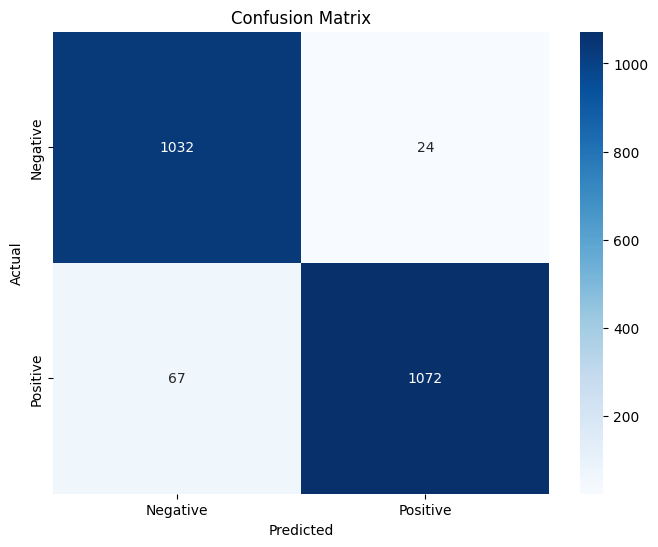

In [129]:
# Plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

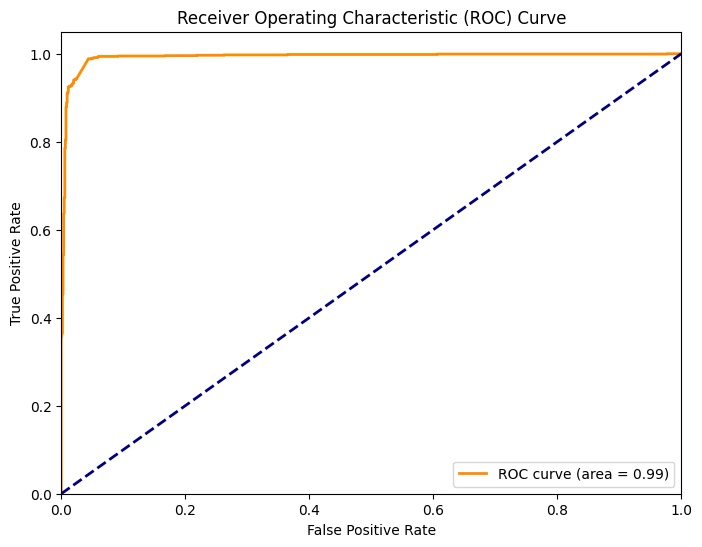

In [130]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [131]:
torch.cuda.empty_cache()

## Performance Comparison on Augmented Data Samples

The idea behind this is to expose both models to altered data samples and determine if adversarial sample training is effective against this form of attack

In [132]:
import nltk
from nltk.corpus import wordnet

nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\guimo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\guimo\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [133]:
import random

def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name().replace('_', ' '))
    return list(synonyms)

def synonym_replacement(words, n):
    new_words = words.copy()
    random_word_list = list(set([word for word in words if wordnet.synsets(word)]))
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        if len(synonyms) >= 1:
            synonym = random.choice(synonyms)
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        if num_replaced >= n:  # only replace up to n words
            break
    return new_words

def random_insertion(words, n):
    new_words = words.copy()
    for _ in range(n):
        add_word(new_words)
    return new_words

def add_word(new_words):
    synonyms = []
    counter = 0
    while len(synonyms) < 1:
        random_word = new_words[random.randint(0, len(new_words)-1)]
        synonyms = get_synonyms(random_word)
        counter += 1
        if counter >= 10:
            return  # if can't find a synonym in 10 tries, return
    random_synonym = synonyms[random.randint(0, len(synonyms)-1)]
    random_idx = random.randint(0, len(new_words)-1)
    new_words.insert(random_idx, random_synonym)

def random_deletion(words, n):
    if len(words) <= 1:
        return words
    new_words = words.copy()
    num_deleted = 0
    
    while num_deleted < n and len(new_words) > 1:
        delete_index = random.randint(0, len(new_words) - 1)
        new_words.pop(delete_index)
        num_deleted += 1
    
    return new_words

def random_swap(words, n):
    new_words = words.copy()
    for _ in range(n):
        new_words = swap_word(new_words)
    return new_words

def swap_word(new_words):
    if len(new_words) < 2:
        return new_words
    random_idx_1 = random.randint(0, len(new_words)-1)
    if random_idx_1 == 0:
        random_idx_2 = random_idx_1 + 1
    elif random_idx_1 == len(new_words) - 1:
        random_idx_2 = random_idx_1 - 1
    else:
        random_idx_2 = random_idx_1 + random.choice([-1, 1])

    new_words[random_idx_1], new_words[random_idx_2] = new_words[random_idx_2], new_words[random_idx_1]
    return new_words

def augment_sentence(sentence, transform_rate=0.1):
    words = sentence.split()
    num_words = len(words)
    
    if num_words == 0:
        return sentence
    
    augmented_sentences = []
    
    # Synonym Replacement
    num_replacements = max(1, int(transform_rate * num_words))
    new_words = synonym_replacement(words, num_replacements)
    augmented_sentences.append(' '.join(new_words))
    
    # Random Insertion
    num_insertions = max(1, int(transform_rate * num_words))
    new_words = random_insertion(words, num_insertions)
    augmented_sentences.append(' '.join(new_words))
    
    # Random Deletion
    num_deletions = max(1, int(transform_rate * num_words))
    new_words = random_deletion(words, num_deletions)
    augmented_sentences.append(' '.join(new_words))
    
    # Random Swap
    num_swaps = max(1, int(transform_rate * num_words))
    new_words = random_swap(words, num_swaps)
    augmented_sentences.append(' '.join(new_words))
    
    return augmented_sentences

# Example usage
sentence = "This is a sample email message to be augmented."
augmented_sentence = augment_sentence(sentence)
print(augmented_sentence)

['This is a sample email message to be augmented.', 'This is a subject matter sample email message to be augmented.', 'This is a sample email to be augmented.', 'This is sample a email message to be augmented.']


In [134]:
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
generator = torch.Generator().manual_seed(4)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [135]:
test_samples = texts_clean.values[test_dataset.indices]
test_labels = encoded_labels.values[test_dataset.indices]
augmented_test_samples = []
augmented_test_labels = []

for i, sample in enumerate(test_samples):
    augmented_test_samples.extend(augment_sentence(sample, transform_rate=0.3))
    augmented_test_labels.extend([test_labels[i]]*4) # There are 4 types of augmentation techniques

In [136]:
augmented_test_dataset = TextDataset(augmented_test_samples, augmented_test_labels, word2index)
augmented_test_loader = DataLoader(augmented_test_dataset, batch_size=32, shuffle=False)

### Regular Model Performance

In [137]:
model = TransformerModel(embedding_matrix)
# Load model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

TransformerModel(
  (embedding): Embedding(123768, 128)
  (dropout): Dropout(p=0.3, inplace=False)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=2048, bias=True)
        (dropout): Dropout(p=0.3, inplace=False)
        (linear2): Linear(in_features=2048, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.3, inplace=False)
        (dropout2): Dropout(p=0.3, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [89]:
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

for seed in range(5):
    # Load the best model
    model.load_state_dict(torch.load(f'Models/custom/best_custom_model_{seed}.pt'))
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in augmented_test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

    # Print metrics
    print(f'\nIteration: {seed}')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')


Iteration: 0
Accuracy: 0.9748
Precision: 0.9734
Recall: 0.9783
F1 Score: 0.9758

Iteration: 1
Accuracy: 0.9780
Precision: 0.9660
Recall: 0.9925
F1 Score: 0.9791

Iteration: 2
Accuracy: 0.9705
Precision: 0.9586
Recall: 0.9857
F1 Score: 0.9720

Iteration: 3
Accuracy: 0.9794
Precision: 0.9726
Recall: 0.9881
F1 Score: 0.9803

Iteration: 4
Accuracy: 0.9604
Precision: 0.9507
Recall: 0.9741
F1 Score: 0.9623


In [90]:
print('Overall:')
print(f'Average Accuracy: {np.mean(accuracy_list)}')
print(f'Average Precision: {np.mean(precision_list)}')
print(f'Average Recall: {np.mean(recall_list)}')
print(f'Average F1: {np.mean(f1_list)}')

Overall:
Average Accuracy: 0.972619589977221
Average Precision: 0.9642546815538436
Average Recall: 0.9837576821773485
Average F1: 0.9738904251014915


In [91]:
torch.cuda.empty_cache()

### Adversarial Model Performance

In [138]:
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

for seed in range(5):
    # Load the best model
    model.load_state_dict(torch.load(f'Models/custom/best_adv_custom_model_{seed}.pt'))
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in augmented_test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

    # Print metrics
    print(f'\nIteration: {seed}')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')


Iteration: 0
Accuracy: 0.9674
Precision: 0.9485
Recall: 0.9910
F1 Score: 0.9693

Iteration: 1
Accuracy: 0.9552
Precision: 0.9674
Recall: 0.9456
F1 Score: 0.9564

Iteration: 2
Accuracy: 0.9580
Precision: 0.9731
Recall: 0.9451
F1 Score: 0.9589

Iteration: 3
Accuracy: 0.9730
Precision: 0.9637
Recall: 0.9851
F1 Score: 0.9743

Iteration: 4
Accuracy: 0.9476
Precision: 0.9604
Recall: 0.9377
F1 Score: 0.9489


In [139]:
print('Overall:')
print(f'Average Accuracy: {np.mean(accuracy_list)}')
print(f'Average Precision: {np.mean(precision_list)}')
print(f'Average Recall: {np.mean(recall_list)}')
print(f'Average F1: {np.mean(f1_list)}')

Overall:
Average Accuracy: 0.960250569476082
Average Precision: 0.9626433273606387
Average Recall: 0.9608867427568043
Average F1: 0.961555484332678


In [140]:
torch.cuda.empty_cache()

# Explainable AI

We analyze some samples from the testing dataset in order to visualize the weight of certain words towards the final prediction of our model

In [21]:
model = TransformerModel(embedding_matrix)

# Load model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

generator = torch.Generator().manual_seed(4)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model.load_state_dict(torch.load(f'Models/custom/best_adv_custom_model_4.pt'))
model.eval()

TransformerModel(
  (embedding): Embedding(123768, 128)
  (dropout): Dropout(p=0.3, inplace=False)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=2048, bias=True)
        (dropout): Dropout(p=0.3, inplace=False)
        (linear2): Linear(in_features=2048, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.3, inplace=False)
        (dropout2): Dropout(p=0.3, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [22]:
# Define a function to predict probabilities using your model
def predict_probability(inputs):
    inputs = [tokenize_text(input) for input in inputs]

    all_probs = []
    batch_size = 32

    for i in range(0, len(inputs), batch_size):
        batch_inputs = inputs[i:i+batch_size]
        with torch.no_grad():
            batch_inputs = torch.tensor(batch_inputs, dtype=torch.int64).to(device)
            outputs = model(batch_inputs)
            probs = torch.sigmoid(outputs).detach().cpu()
            all_probs.extend(probs)
    return np.vstack(all_probs)

# Define a function to tokenize the input text
def tokenize_text(text, word2index=word2index, max_len=1024):
    text = text.split()
    indices = [word2index.get(word, 0) for word in text]  # Use 0 for unknown words
    if len(indices) < max_len:
        indices = indices + [0] * (max_len - len(indices))
    indices = indices[:max_len]
    return indices

In [23]:
# Load some samples to explain
sample_texts = [texts_clean.values[i] for i in test_dataset.indices]
sample_labels = [encoded_labels.values[i] for i in test_dataset.indices]

For this purpose, we make use of Lime values

In [24]:
from lime.lime_text import LimeTextExplainer

explainer = LimeTextExplainer(class_names=["Phishing"])

In [25]:
from IPython.display import display, HTML

def show_explanation(exp):
    html_data = exp.as_html()
    html_with_white_background = f"""
    <div style="background-color: white; padding: 10px;">
        {html_data}
    </div>
    """
    display(HTML(html_with_white_background))

In [26]:
exp = explainer.explain_instance(sample_texts[1], predict_probability, 
                                 num_features=10, 
                                 top_labels=1, 
                                 num_samples=1024)

c:\Users\guimo\Downloads\PyTorch\env\Lib\site-packages\torch\nn\modules\transformer.py:720: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  return torch._transformer_encoder_layer_fwd(


In [27]:
show_explanation(exp)

In [34]:
exp2 = explainer.explain_instance(sample_texts[2], predict_probability, 
                                 num_features=10, 
                                 top_labels=1, 
                                 num_samples=1024)

In [35]:
show_explanation(exp2)

In [36]:
exp3 = explainer.explain_instance(sample_texts[0], predict_probability, 
                                 num_features=10, 
                                 top_labels=1, 
                                 num_samples=1024)

In [38]:
show_explanation(exp3)

In [46]:
exp4 = explainer.explain_instance(sample_texts[7], predict_probability, 
                                 num_features=10, 
                                 top_labels=1, 
                                 num_samples=1024)

In [47]:
show_explanation(exp4)

## Test on ChatGPT emails

In [30]:
df2 = pd.read_csv("./chatgpt_emails.csv")
all_labels = df2["Label"].values
all_labels = LabelEncoder().fit_transform(all_labels)

In [31]:
all_probs = [parse_sentence(text) for text in df2["Content"].values]
all_probs = predict_probability(all_probs).reshape(-1)
all_preds = np.where(all_probs < 0.5, 1, 0)

In [32]:
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.8800
Precision: 0.9130
Recall: 0.8400
F1 Score: 0.8750


In [33]:
show_explanation(explainer.explain_instance(parse_sentence(df2["Content"][2]), predict_probability, 
                                 num_features=10, 
                                 top_labels=1, 
                                 num_samples=1024))